In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


In [14]:
# Inits

# elastodynamic wave equation:
# p -- mass density of the material
# u** -- second time derivative of the displacement vector u (i.e. the acceleration of the material particles)
# # u = u(x,t) -- is the displacement vector field, describing how points in the material move over time
# \lambda -- first lame parameter, related to compressibility and stiffness under volume change.
# \mu -- shear modulus, relating to how the material restist shape changes (also called the 2nd lame paramter).
# gradient(gradient * u) -- This term represents longitudinal or compressional wave components (P-waves), arising from divergence in the displacement field.
# gradient^2(u) -- the vector laplacian of the displacement field, related to shear wave propagation (s-waves)
# f -- external bnody force per unit volume acting ont he material (impulse force/gravity)
# This equation describes how internal stresses (due to elastic restoring forces) and external forces cause accelerations in an elastic medium.

def wave_equation(t, x, ):
    """
        Args:
        tx: variables (t, x) as tf.Tensor.
        c: wave velocity.
        k: wave number.
        sd: standard deviation.

        Returns:
        u(t, x) as tf.Tensor.
    """
    return

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class WaveEquation(nn.Module):
    def __init__(self, n_hidden=20): # n_hidden = num of neurons in hidden layer
        super(WaveEquation, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x, t):
        input = torch.cat([x, t], dim=1)
        return self.net(input)
    
# initiize
model = WaveEquation()

cpu


In [15]:
# Loss Functions

# wave equation pde: ∂²u/∂t² = c²∇²u
# also written as:   ∂²u/∂t² = c²∂²u/∂x²
def wave_pde_loss(model, x, t, c):
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    u = model(x,t) # what will this predicted output look like?
    #print(u)
    
    du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    return torch.mean((d2u_dt2 - ((c **2) * d2u_dx2)) **2)

# u(x,0) = f(x), ∂u/∂t(x, 0) = g(x) = x(π - x)
# Initial condition loss: u(x,0) = sin(pi x)
def initial_loss(model, x_ic):
    t_ic = torch.zeros_like(x_ic)
    u_ic_pred = model(x_ic, t_ic)
    u_ic_true = torch.sin(torch.pi * x_ic)
    return torch.mean((u_ic_pred - u_ic_true) ** 2)

# Boundary condition loss: u(0,t) = u(1,t) for one dimension (x)
def boundary_loss(model, t_bc):
    t_bc.requires_grad_(True)  # Needed for autograd
    x_left = torch.zeros_like(t_bc).requires_grad_(True) # A tensor of zeros (same shape as t_bc) used to evaluate u(0,t)
    x_right = torch.ones_like(t_bc).requires_grad_(True) # x_right: A tensor of ones (same shape as t_bc), used to evaluate u(1,t)
    u_left = model(x_left, t_bc).requires_grad_(True)
    u_right = model(x_right, t_bc).requires_grad_(True)
    
    # Derivatives ∂u/∂x at x = 0 and x = 1
    du_dx_left = torch.autograd.grad(u_left, x_left, grad_outputs=torch.ones_like(u_left),
                                     retain_graph=True, create_graph=True)[0]
    du_dx_right = torch.autograd.grad(u_right, x_right, grad_outputs=torch.ones_like(u_right),
                                      retain_graph=True, create_graph=True)[0]

    # Neumann target values: here, 0 (no-flux condition)
    neumann_target = torch.zeros_like(du_dx_left)

    return torch.mean((du_dx_left - neumann_target) ** 2) + torch.mean((du_dx_right - neumann_target) ** 2)

In [16]:
# Generate dummy training data (x, t)
n_phys = 300
x_phys = torch.rand((n_phys, 1), requires_grad=True).to(device)
t_phys = torch.rand((n_phys, 1), requires_grad=True).to(device)
c = 1.0

n_ic = 200
x_ic = torch.rand((n_ic, 1)).to(device) # Randomly sampled spatial points at time t = 0 where we know the true value of u

n_bc = 200
t_bc = torch.rand((n_bc, 1)).to(device) # Random time values used for applying boundary conditions at the spatial edges x = 0 & x = 1

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Weights for each loss
lambda_wave, lambda_ic, lambda_bc = 1.0, 0.5, 0.5

# Lists of loss values for tracking/plotting
total_loss_values, loss_wave_values, loss_ic_values, loss_bc_values = [], [], [], []

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    loss_wave = wave_pde_loss(model, x_phys, t_phys, c)
    loss_ic = initial_loss(model, x_ic)
    loss_bc = boundary_loss(model, t_bc)

    total_loss = (lambda_wave * loss_wave) + (lambda_ic * loss_ic) + (lambda_bc * loss_bc)
    total_loss.backward()
    optimizer.step()
    
    #Store the scalar values for plotting
    loss_wave_values.append(loss_wave.item())
    loss_ic_values.append(loss_ic.item())
    loss_bc_values.append(loss_bc.item())
    total_loss_values.append(total_loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} - Total Loss: {total_loss.item():.6f}")
        print(f"   Wave PDE Loss: {loss_wave.item():.6f}")

Epoch 0 - Total Loss: 0.153347
   Wave PDE Loss: 0.000160


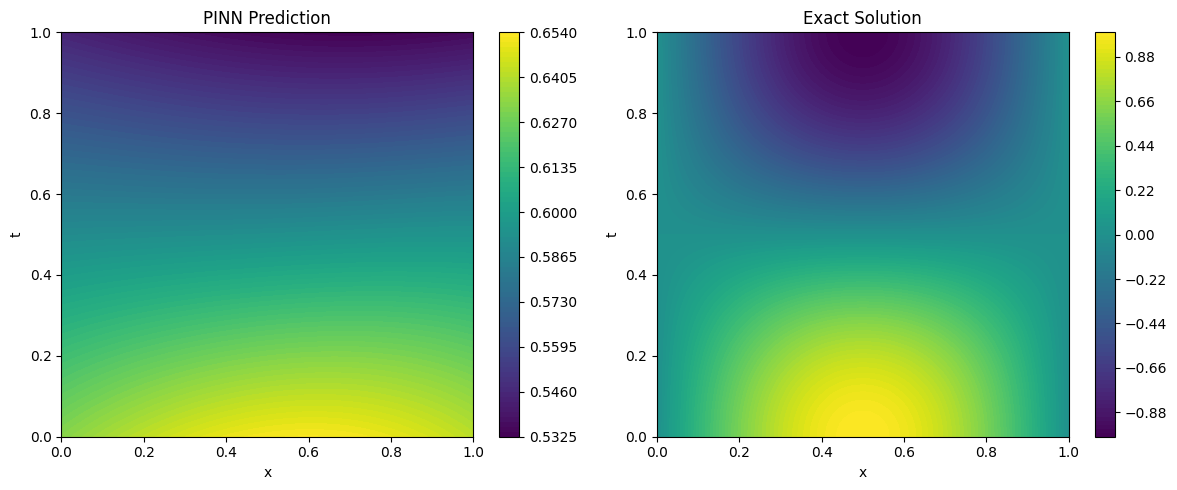

In [17]:
model.eval()

# Create evaluation mesh grid
x_eval = torch.linspace(0, 1, 100).view(-1, 1)
t_eval = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')

x_flat = X.reshape(-1, 1).to(device)
t_flat = T.reshape(-1, 1).to(device)

# Predict with trained model
with torch.no_grad():
    u_pred = model(x_flat, t_flat).cpu().numpy()

# Reshape to grid for plotting
U_pred = u_pred.reshape(100, 100)

# Compute exact solution
X_np = X.cpu().numpy()
T_np = T.cpu().numpy()
U_exact = np.sin(np.pi * X_np) * np.cos(np.pi * T_np)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

c1 = axs[0].contourf(X_np, T_np, U_pred, 100, cmap='viridis')
axs[0].set_title("PINN Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].contourf(X_np, T_np, U_exact, 100, cmap='viridis')
axs[1].set_title("Exact Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
fig.colorbar(c2, ax=axs[1])
# color intensity shows the value of u(x,t) inside our bounds

plt.tight_layout()
plt.show()

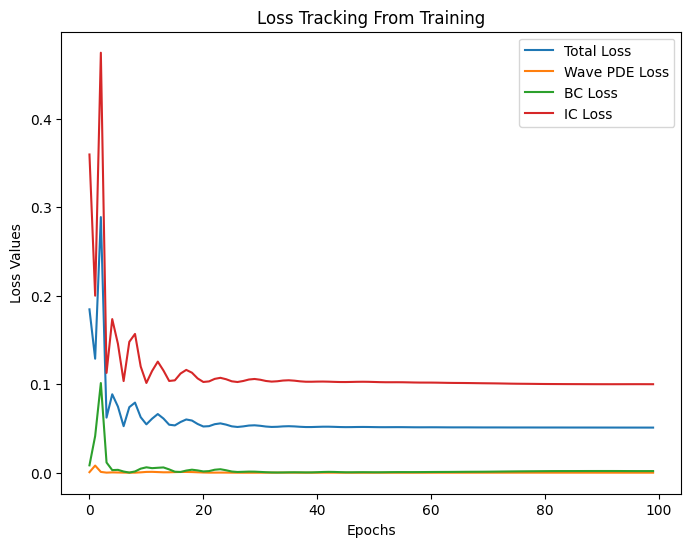

In [307]:
model.eval()

plt.figure(figsize=(8,6))

plt.plot(total_loss_values, label="Total Loss")
plt.plot(loss_wave_values, label="Wave PDE Loss")
plt.plot(loss_bc_values, label="BC Loss")
plt.plot(loss_ic_values, label="IC Loss")

plt.legend()

plt.title("Loss Tracking From Training")
plt.xlabel("Epochs")
plt.ylabel("Loss Values")

plt.show()